<a href="https://colab.research.google.com/github/FelipeYacobian/Panda/blob/main/VCProjetoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"viniciusblanco","key":"a4c767c469d0329692dd29201794315a"}'}

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset


Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 95% 1.93G/2.04G [00:22<00:04, 27.5MB/s]
100% 2.04G/2.04G [00:22<00:00, 96.7MB/s]


In [ ]:
import zipfile
import os

zip_file_name = 'plantvillage-dataset.zip' # O nome do arquivo zip baixado
extract_dir = 'plantvillage_dataset' # Onde você quer extrair os arquivos

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f'Dataset extraído para: {extract_dir}')


Dataset extraído para: plantvillage_dataset


# Projeto de Visão Computacional - PlantVillage (CNN)

Este notebook faz parte do projeto prático de **Visão Computacional** com o dataset **PlantVillage**, cujo objetivo é **classificar doenças em folhas de plantas** usando **redes neurais convolucionais (CNNs)**.

---
Organizado da seguinte forma:

1.   Entender o dataset → (carregar, ver quantas classes e imagens temos) **(EDA)**

2.   Preparar os dados → (aumentar artificialmente, normalizar, dividir treino validação/teste).

3. Criar o modelo → (primeiro uma CNN simples do zero).

4. Treinar e avaliar → (ver acurácia, overfitting etc.).

5. Usar Transfer Learning (fine tuning) → (modelo pré-treinado, ex: MobileNetV2).

6. Comparar resultados → (qual teve melhor desempenho e generalização).





### Importando bibliotecas


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory


## 1. Entendimento do Dataset (EDA)

Vamos carregar o dataset **PlantVillage**, que contém imagens de folhas de plantas saudáveis e doentes, separadas por classes com cada pasta representando uma classe


In [ ]:

dataset_origin = "/content/plantvillage_dataset/plantvillage dataset"  # ajuste conforme o caminho real
dataset_path = os.path.join(dataset_origin, "color")
# Visualizar as classes
classes = os.listdir(dataset_path)
print(f"Classes encontradas ({len(classes)}):")
print(classes[:10])  # mostra as 10 primeiras classes


Classes encontradas (38):
['Tomato___Bacterial_spot', 'Potato___healthy', 'Corn_(maize)___Common_rust_', 'Strawberry___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Target_Spot', 'Apple___Cedar_apple_rust', 'Tomato___Septoria_leaf_spot', 'Blueberry___healthy', 'Apple___healthy']


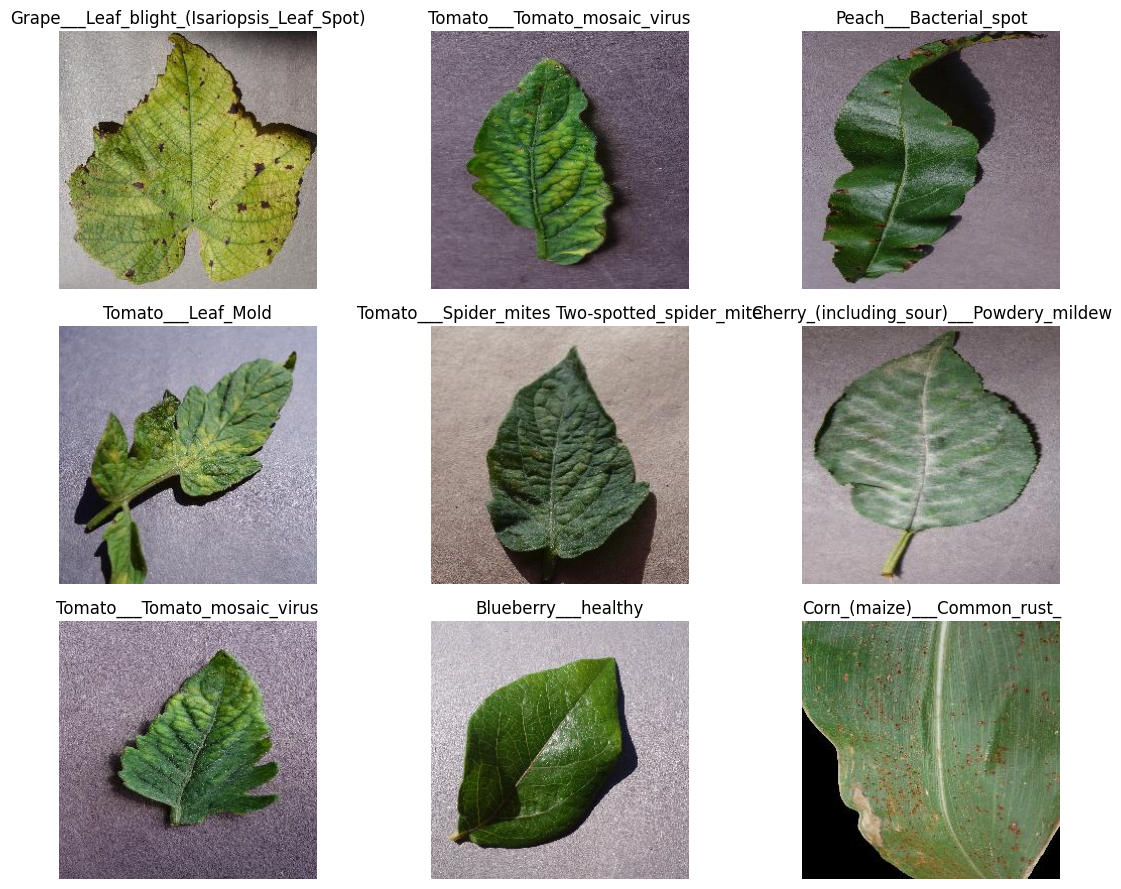

In [ ]:
#Para visualizar algumas imagens
import random
import matplotlib.image as mpimg

plt.figure(figsize=(12, 9))
for i in range(9):
    label = random.choice(classes)
    img_path = os.path.join(dataset_path, label, random.choice(os.listdir(os.path.join(dataset_path, label))))
    img = mpimg.imread(img_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()


## 2. Preparação dos Dados

Agora vamos:
1. Dividir o dataset em treino, validação e teste.  
2. Normalizar os valores dos pixels (0–1).  
3. Aplicar Data Augmentation para gerar variações artificiais e evitar overfitting.


In [ ]:
# Parâmetros
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42


#Criando conjuntos de treino e validação
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Found 54305 files belonging to 38 classes.
Using 10861 files for validation.


In [ ]:
# Normalizando os valores dos pixels de 0 a 1.
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

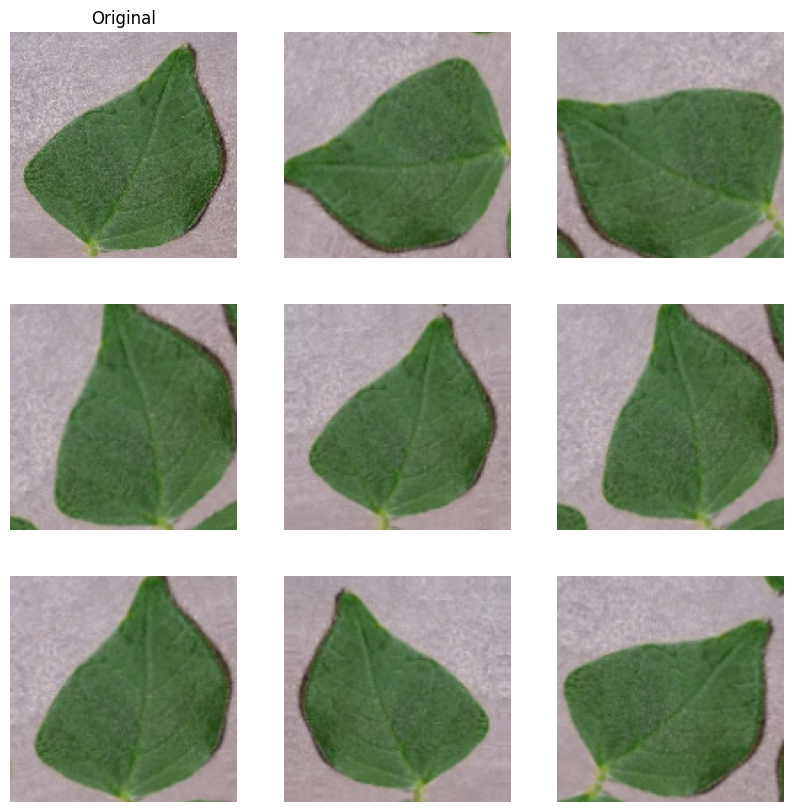

In [ ]:
# Aplicando o Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), # Espelha horizontalmente
    tf.keras.layers.RandomRotation(0.2), # rotaciona a imagem aleatoriamente até +-20% de 180°
    tf.keras.layers.RandomZoom(0.1),  # Aplica zoom aleatório
])

# Visualizar exemplos de imagens alteradas
for images, labels in train_ds.take(1):

  plt.figure(figsize=(10, 10))
  # Exibir a imagem original (posição 0)
  original_image = images[0]
  ax = plt.subplot(3, 3, 1)
  plt.imshow(original_image.numpy())
  plt.title("Original")
  plt.axis("off")

  for i in range(1, 9):
      augmented_image = data_augmentation(images)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_image[0].numpy())
      plt.axis("off")
  break


# 3. Criação do Modelo (CNN do Zero)

Agora vamos construir uma **CNN simples** usando o *Sequential* do Keras.

- Camadas convolucionais (*Conv2D*) extraem padrões da imagem (bordas, texturas, etc).  
- Camadas de pooling (*MaxPooling2D*) reduzem a dimensão e mantêm as features mais relevantes.  
- *Dropout* ajuda a evitar overfitting.  
- *Dense* faz a classificação final (softmax = probabilidade para cada classe).


In [ ]:
from tensorflow.keras import layers, models

# Número de classes do dataset
num_classes = len(classes)
# Definindo a forma da imagem (IMG_SIZE foi definido no Tópico 2)
IMG_SHAPE = IMG_SIZE + (3,) # (128, 128, 3)

#Modelo CNN simples
model = models.Sequential([
    # 1. Camada de Entrada
    # Corrigido: O input_shape deve ser a primeira camada
    layers.Input(shape=IMG_SHAPE),

    # 2. Data Augmentation
    data_augmentation,

    # 3. Bloco Convolucional 1
    # Removido o input_shape daqui
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # 4. Bloco Convolucional 2
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # 5. Bloco Convolucional 3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # 6. Camadas de Classificação
    layers.Flatten(),
    layers.Dropout(0.5), # Regularização
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax') # Camada de saída
])

# ---- Compilação do Modelo ----
# Adicionamos a compilação ao final da criação
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Resumo da arquitetura
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,309,542 (12.62 MB)

 Trainable params: 3,309,542 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

#4. Treinar e Avaliar

Nesta etapa, vamos compilar e treinar o modelo que acabamos de criar.

- Compilação: Usaremos o otimizador adam e a função de perda (loss) sparse_categorical_crossentropy, monitorando a accuracy (acurácia).
- Treinamento: Iniciaremos o treino com model.fit(), passando os dados de treino (train_ds) e validação (val_ds) por um número definido de épocas.
- Avaliação: Ao final, vamos plotar os gráficos de acurácia e perda para analisar o desempenho do modelo e verificar se ocorreu overfitting (comparando os resultados de treino com os de validação).



Iniciando Treino da CNN Simples (do Zero)...
Epoch 1/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.4760 - loss: 1.9168 - val_accuracy: 0.6971 - val_loss: 1.0261
Epoch 2/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - accuracy: 0.7870 - loss: 0.6918 - val_accuracy: 0.8152 - val_loss: 0.5822
Epoch 3/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.8492 - loss: 0.4897 - val_accuracy: 0.8133 - val_loss: 0.6096
Epoch 4/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.8748 - loss: 0.3973 - val_accuracy: 0.8432 - val_loss: 0.4904
Epoch 5/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - accuracy: 0.8898 - loss: 0.3398 - val_accuracy: 0.9000 - val_loss: 0.3162
Epoch 6/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.9099 - loss: 0.2804 - val_accuracy: 0.9163 - val_loss: 0.2570
Epoch 7/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - accuracy: 0.9121 - loss: 0.2708 - val_accuracy: 0.8837 - val_loss: 0.3635
Epoch 8/15
1358/1358 ━━━━━━━━━━

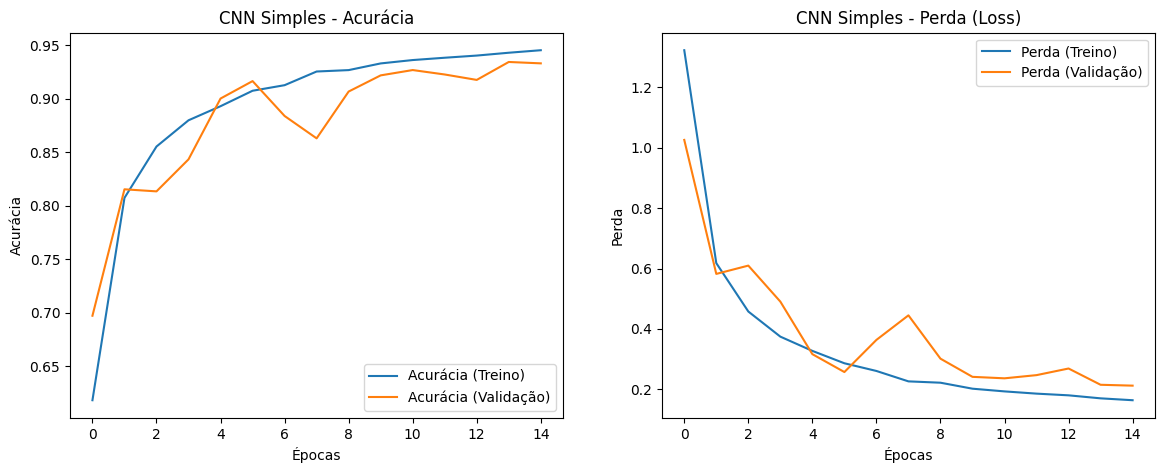

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Iniciando Treino da CNN Simples (do Zero)...")

EPOCHS_SIMPLE = 15

history_simple = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_SIMPLE
)

print("\n--- Avaliação da CNN Simples ---")

val_loss_simple, val_acc_simple = model.evaluate(val_ds)
print(f"Acurácia de Validação (CNN Simples): {val_acc_simple * 100:.2f}%")
print(f"Perda (Loss) de Validação: {val_loss_simple:.4f}")

print("\nPlotando gráficos de treino e validação...")

acc = history_simple.history['accuracy']
val_acc = history_simple.history['val_accuracy']
loss = history_simple.history['loss']
val_loss = history_simple.history['val_loss']
epochs_range = range(EPOCHS_SIMPLE)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia (Treino)')
plt.plot(epochs_range, val_acc, label='Acurácia (Validação)')
plt.legend(loc='lower right')
plt.title('CNN Simples - Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda (Treino)')
plt.plot(epochs_range, val_loss, label='Perda (Validação)')
plt.legend(loc='upper right')
plt.title('CNN Simples - Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.show()

## Para o modelo:
Escolhemos:
- **Optimizer**: *adam* → bom ponto de partida para CNNs.  
- **Loss**: *sparse_categorical_crossentropy* → usado para classes inteiras (não one-hot).  


#5. Usar Transfer Learning (MobileNetV2)

Em vez de começar do zero, vamos usar um modelo "profissional" (MobileNetV2) que já sabe identificar padrões.

Nosso trabalho é apenas adaptá-lo:

- Fase 1 (Extração): "Congelamos" o MobileNetV2 e treinamos apenas uma nova camada final (para as nossas 38 classes de plantas).

- Fase 2 (Ajuste Fino): "Descongelamos" parte do modelo e treinamos tudo de novo, mas bem devagar (com learning rate baixo), para ele se especializar nas nossas imagens.

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 54s 36ms/step - accuracy: 0.6360 - loss: 1.3083 - val_accuracy: 0.8566 - val_loss: 0.4419
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 46s 34ms/step - accuracy: 0.8220 - loss: 0.5530 - val_accuracy: 0.8697 - val_loss: 0.3941
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - accuracy: 0.8418 - loss: 0.4891 - val_accuracy: 0.8819 - val_loss: 0.3533
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 83s 36ms/step - accuracy: 0.8496 - loss: 0.4624 - val_accuracy: 0.8840 - val_loss: 0.3539
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - accuracy: 0.8542 - loss: 0.4491 - val_accuracy: 0.8925 - val_loss: 0.3267
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 46s 34ms/step - accuracy: 0.8622 - loss: 0.4228 - val_accuracy: 0.8893 - val_loss: 0.3326
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 47s 34ms/step - accuracy: 0.8628 - loss: 0.4184 - val_accuracy: 0.9006 - val_loss: 0.2948
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - accuracy: 0.8615 -

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 2,030,310 (7.75 MB)

 Non-trainable params: 396,544 (1.51 MB)

Epoch 10/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 92s 59ms/step - accuracy: 0.5577 - loss: 2.4877 - val_accuracy: 0.8867 - val_loss: 0.3630
Epoch 11/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 81s 60ms/step - accuracy: 0.8143 - loss: 0.6543 - val_accuracy: 0.8945 - val_loss: 0.3296
Epoch 12/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 78s 57ms/step - accuracy: 0.8549 - loss: 0.4866 - val_accuracy: 0.9019 - val_loss: 0.2980
Epoch 13/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 78s 58ms/step - accuracy: 0.8785 - loss: 0.3766 - val_accuracy: 0.9125 - val_loss: 0.2625
Epoch 14/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 78s 58ms/step - accuracy: 0.8932 - loss: 0.3396 - val_accuracy: 0.9226 - val_loss: 0.2238
Epoch 15/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 78s 58ms/step - accuracy: 0.9063 - loss: 0.2870 - val_accuracy: 0.9270 - val_loss: 0.2111
Epoch 16/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 80s 59ms/step - accuracy: 0.9177 - loss: 0.2460 - val_accuracy: 0.9384 - val_loss: 0.1822
Epoch 17/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 78s 57ms/step - accuracy: 

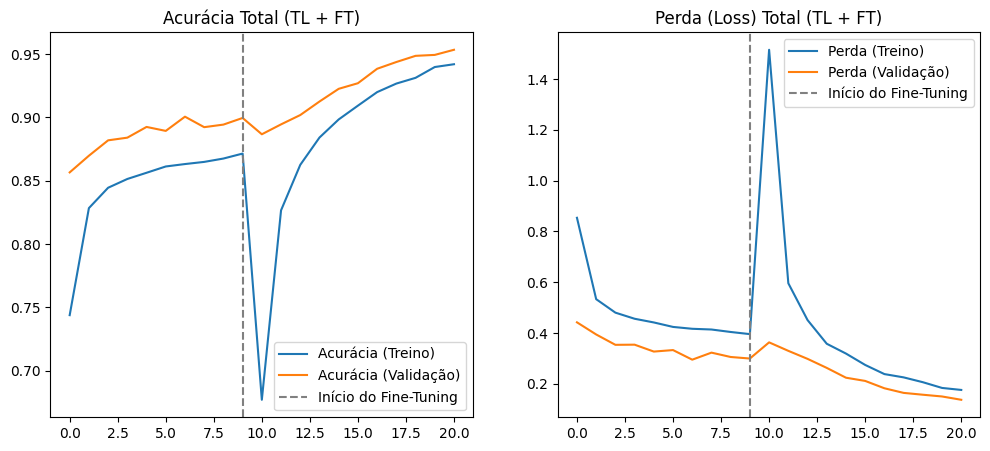

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# --- 5.1 Carregando e Treinando (Feature Extraction) ---

IMG_SHAPE = IMG_SIZE + (3,)

base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_tl = Model(inputs, outputs)

model_tl.compile(optimizer=Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

model_tl.summary()

EPOCHS_TL = 10
history_tl = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_TL
)

val_loss, val_acc = model_tl.evaluate(val_ds)
print(f"Acurácia de Validação (Feature Extraction): {val_acc * 100:.2f}%")

# --- 5.2 Ajuste Fino (Fine-Tuning) ---

base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model_tl.compile(optimizer=Adam(learning_rate=1e-5),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

model_tl.summary()

EPOCHS_FT = 10
total_epochs = EPOCHS_TL + EPOCHS_FT

history_ft = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history_tl.epoch[-1]
)

val_loss, val_acc = model_tl.evaluate(val_ds)
print(f"Acurácia de Validação (Final Fine-Tuning): {val_acc * 100:.2f}%")

# --- Plotando os Gráficos Finais ---

acc = history_tl.history['accuracy'] + history_ft.history['accuracy']
val_acc = history_tl.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history_tl.history['loss'] + history_ft.history['loss']
val_loss = history_tl.history['val_loss'] + history_ft.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Acurácia (Treino)')
plt.plot(val_acc, label='Acurácia (Validação)')
plt.axvline(EPOCHS_TL - 1, color='gray', linestyle='--', label='Início do Fine-Tuning')
plt.title('Acurácia Total (TL + FT)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Perda (Treino)')
plt.plot(val_loss, label='Perda (Validação)')
plt.axvline(EPOCHS_TL - 1, color='gray', linestyle='--', label='Início do Fine-Tuning')
plt.title('Perda (Loss) Total (TL + FT)')
plt.legend()

plt.show()

#6. Comparar resultados (qual teve melhor desempenho e generalização).

**Com os dois modelos treinados, podemos finalmente comparar seus resultados para determinar qual abordagem foi a melhor.**

*Comparação de Desempenho*
O principal indicador de sucesso é a acurácia final nos dados de validação (dados que o modelo nunca viu durante o treino).

Os resultados da comparação dos modelos foram os seguintes:

O modelo CNN Simples (do Zero) alcançou uma acurácia
de validação final de 93.29%.

O modelo de Transfer Learning (MobileNetV2) alcançou uma acurácia
de validação final de 95.34%.

**Análise de Desempenho e Generalização**
**Desempenho** (Acurácia):

O modelo de Transfer Learning (MobileNetV2) foi o vencedor, alcançando 95.34% de acurácia, contra 93.29% da CNN Simples.

Embora a CNN simples tenha tido um resultado impressionante para um modelo treinado do zero (93.29% é muito bom!), a técnica de Transfer Learning, que aproveita o conhecimento prévio do MobileNetV2, se provou superior em desempenho bruto.


**Generalização (Overfitting):**

Aqui a diferença é ainda mais clara, e os gráficos são a prova:

CNN Simples (do Zero): O seu gráfico "CNN Simples - Perda (Loss)" mostra um sinal claro de overfitting. A perda de treino (linha azul) continua caindo, mas a perda de validação (linha laranja) começa a subir e a ficar instável (volátil) por volta da Época 6. Isso significa que o modelo começou a "decorar" as imagens de treino, mas perdeu sua capacidade de generalizar para novas imagens.

Transfer Learning (MobileNetV2): O gráfico "Perda (Loss) (TL + FT)" é quase perfeito. A linha de perda de validação (laranja) se mantém consistentemente abaixo da linha de perda de treino (azul) durante quase todo o processo. Isso indica uma excelente generalização. O modelo se saiu melhor nos dados de validação do que nos de treino (provavelmente devido ao Dropout estar ativo apenas no treino), o que é um sinal fantástico.

**Conclusão Final**
O Transfer Learning (MobileNetV2) é o vencedor.

Ele não só alcançou a maior acurácia final (95.34%), mas, o mais importante, demonstrou uma generalização muito superior, aprendendo padrões reais das doenças das folhas em vez de apenas decorar os dados de treino.

Isso confirma que, para problemas de visão computacional com datasets complexos, usar um modelo pré-treinado (Transfer Learning) é uma estratégia muito mais eficaz e robusta do que construir uma CNN do zero.